## Some Defect Calculation results for $V_{Cd}$

In this example, `vac_1_Cd_0` wasn't generated with `doped`, and so the defect site is not the `doped`-generated one (0,0,0), but (0.5, 0.5, 0.5). `doped` can typically parse the defect fine, automatically determining the defect type and site from the relaxed structure.

In [6]:
from doped import dope_stuff

In [7]:
from doped.pycdt.utils import parse_calculations
import numpy as np
import os

In [3]:
bulk_file_path = "Examples/Bulk_Supercell/vasp_ncl"
dielectric = np.array([[9.13, 0, 0],[0., 9.13, 0],[0, 0, 9.13]])
parsed_vac_Cd_dict = {}

for i in os.listdir("Examples"):
    if 'vac_1_Cd' in i:  # this loops through the folders in the example directory, and parses those that have "vac_1_Cd" in their name
        print(i)
        defect_file_path = f"Examples/{i}/vasp_ncl" # assumes your final calculation results are in subfolders called vasp_ncl. E.g. vac_1_Cd_0/vasp_ncl/ etc
        defect_charge = int(i[-2:].replace("_",""))

        sdp = parse_calculations.SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                            dielectric, defect_charge)
        print(f"Uncorrected energy: {sdp.defect_entry.uncorrected_energy:.3f} eV")
        bo = sdp.freysoldt_loader()
        sdp.get_stdrd_metadata()
        sdp.get_bulk_gap_data()
        sdp.run_compatibility()
        print("Defect entry corrections:")
        print(sdp.defect_entry.corrections)
        print(f"Corrected energy: {sdp.defect_entry.energy:.3f} eV", "\n")
        parsed_vac_Cd_dict[i] = sdp.defect_entry # Keep dictionary of parsed defect entries

vac_1_Cd_-2
Uncorrected energy: 7.661 eV
Defect entry corrections:
{'charge_correction': 0.7376460317828045, 'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: 8.398 eV 

vac_1_Cd_0
Uncorrected energy: 4.166 eV
Defect entry corrections:
{'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: 4.166 eV 

vac_1_Cd_-1
Uncorrected energy: 6.130 eV
Defect entry corrections:
{'charge_correction': 0.22517150393292082, 'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: 6.355 eV 



Note that you could also use something like:
```python
for i in ["vac_1_Cd_-2", "vac_1_Cd_-1", "vac_1_Cd_0"]:
    print("\n",i)
    defect_file_path = f"{i}/vasp_ncl" # assumes your final calculation results are in subfolders called vasp_ncl. E.g. vac_1_Cd_0/vasp_ncl/ etc
    ...
```
to loop over your calculation directories, or any other way you want.

In [4]:
parsed_vac_Cd_dict['vac_1_Cd_0'].site

PeriodicSite: Cd (6.5434, 6.5434, 6.5434) [0.5000, 0.5000, 0.5000]

We can quickly look at the charge correction plots using:

In [7]:
from doped.pycdt.corrections.finite_size_charge_correction import get_correction_freysoldt

Final Freysoldt correction is 0.738 eV


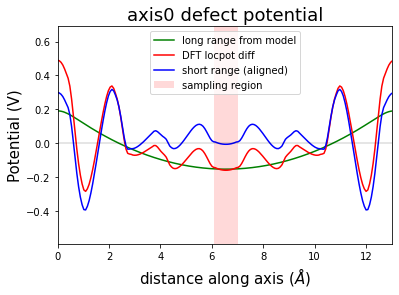

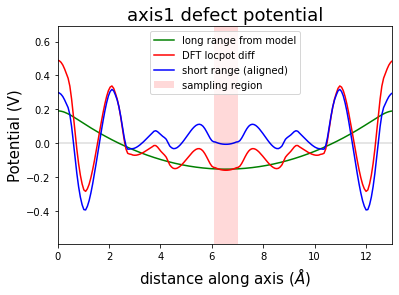

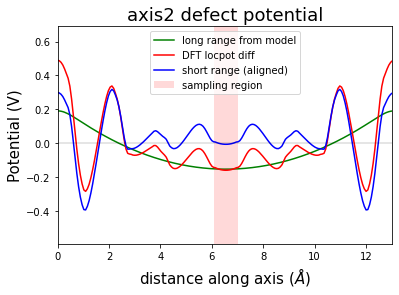

In [9]:
frey_corr = get_correction_freysoldt(parsed_vac_Cd_dict["vac_1_Cd_-2"], dielectric, plot = True)

Note that here we have used the Freysoldt (FNV) image charge correction scheme, with the `sdp.freysoldt_loader()` / `get_correction_freysoldt()` functions, which assumes an isotropic dielectric screening and so should only be used with **_isotropic/cubic host materials_**.
`doped` also supports the Kumagai-Oba (eFNV) charge correction scheme, with the `sdp.kumagai_loader()` / `get_correction_kumagai()` functions, which allows for anisotropic dielectric screening and so should be used for **_anisotropic/non-cubic host materials_**. See the Kumagai-Oba defects charge correction [paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.89.195205) for more details.

#### Kumagai-Oba (eFNV) Charge Correction Example:

In [3]:
bulk_file_path = "Examples/Bulk_Supercell/vasp_ncl"
dielectric = np.array([[9.13, 0, 0],[0., 9.13, 0],[0, 0, 9.13]])

for i in os.listdir("Examples"):
    if 'Int_Te' in i:
        print(i)
        defect_file_path = f"Examples/{i}/vasp_ncl"
        defect_charge = int(i[-2:].replace("_",""))

        sdp = parse_calculations.SingleDefectParser.from_paths(defect_file_path, bulk_file_path,
                                            dielectric, defect_charge)
        print(f"Uncorrected energy: {sdp.defect_entry.uncorrected_energy:.3f} eV")
        bo = sdp.kumagai_loader()
        sdp.get_stdrd_metadata()
        sdp.get_bulk_gap_data()
        sdp.run_compatibility()
        print("Defect entry corrections:")
        print(sdp.defect_entry.corrections)
        print(f"Corrected energy: {sdp.defect_entry.energy:.3f} eV", "\n")

Int_Te_3_2
Uncorrected energy: -7.105 eV
Defect entry corrections:
{'charge_correction': 0.8834518111049584, 'bandfilling_correction': -0.0, 'bandedgeshifting_correction': 0.0}
Corrected energy: -6.221 eV 



In [4]:
from doped.pycdt.corrections.finite_size_charge_correction import get_correction_kumagai


Final Kumagai correction is 0.883 eV


0.8834518111049584

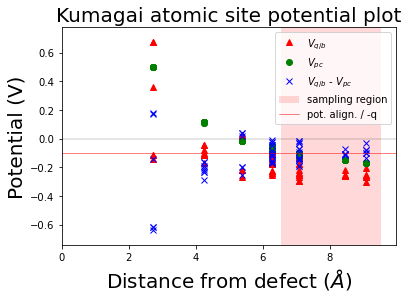

In [5]:
get_correction_kumagai(sdp.defect_entry, epsilon=dielectric, title="Te_i_+2 eFNV Correction")

## The Main Event: Transition Level Diagrams

We can save `doped` dictionaries and python objects using `dope_stuff.save_to_pickle`, then reload them later with `dope_stuff.load_from_pickle`, so we can restart the Python kernel and not have to re-parse everything.

Here, I have already parsed my chemical potential calculations with `doped` (see the `doped_chempot_parsing_example` notebook), and saved it to a pickle file with `dope_stuff.save_to_pickle`, so that I can reload it in a new notebook (or new session with the same notebook), as below:

In [7]:
# load CdTe parsed chemical potentials (see `doped_chempot_parsing_example.ipynb` for parsing chemical potentials) for computing defect formation energies
cdte_chempots = dope_stuff.load_from_pickle('Examples/cdte_chempot_limits.pickle')

In [16]:
print(cdte_chempots)

{'facets': {'Cd-CdTe': {Element Cd: -1.01586484, Element Te: -5.7220097228125}, 'CdTe-Te': {Element Cd: -2.2671822228125, Element Te: -4.47069234}}, 'elemental_refs': {Element Te: -4.47069234, Element Cd: -1.01586484}, 'facets_wrt_elt_refs': {'Cd-CdTe': {Element Cd: 0.0, Element Te: -1.2513173828125002}, 'CdTe-Te': {Element Cd: -1.2513173828125, Element Te: 0.0}}}


Some of the advantages of parsing / manipulating your chemical potential calculations this way, is that:

- You can quickly loop through different points in chemical potential space (i.e. phase diagram facets), rather than typing out the chemical potentials obtained from a different method (e.g. from `CPLAP`).
- `doped` automatically determines the chemical potentials with respect to elemental references (i.e. chemical potentials are zero in their standard states (by definition), rather than VASP/DFT energies). This is the `facets_wrt_elt_refs` entry in the `cdte_chempots` dict in the cell above.
- `doped` can then optionally print the corresponding phase diagram facet / chemical potential limit and the _formal_ chemical potentials of the elements at that point, above the formation energy plot, as shown in the next cell.

Alternatively, you can directly feed in pre-calculated chemical potentials to `doped`, see below for this.

In [14]:
# generate DefectPhaseDiagram object so we can plot/tabulate formation energies, calculate charge transition levels etc:
vac_Cd_dpd = dope_stuff.dpd_from_parsed_defect_dict(parsed_vac_Cd_dict)

Basic formation energy plot:

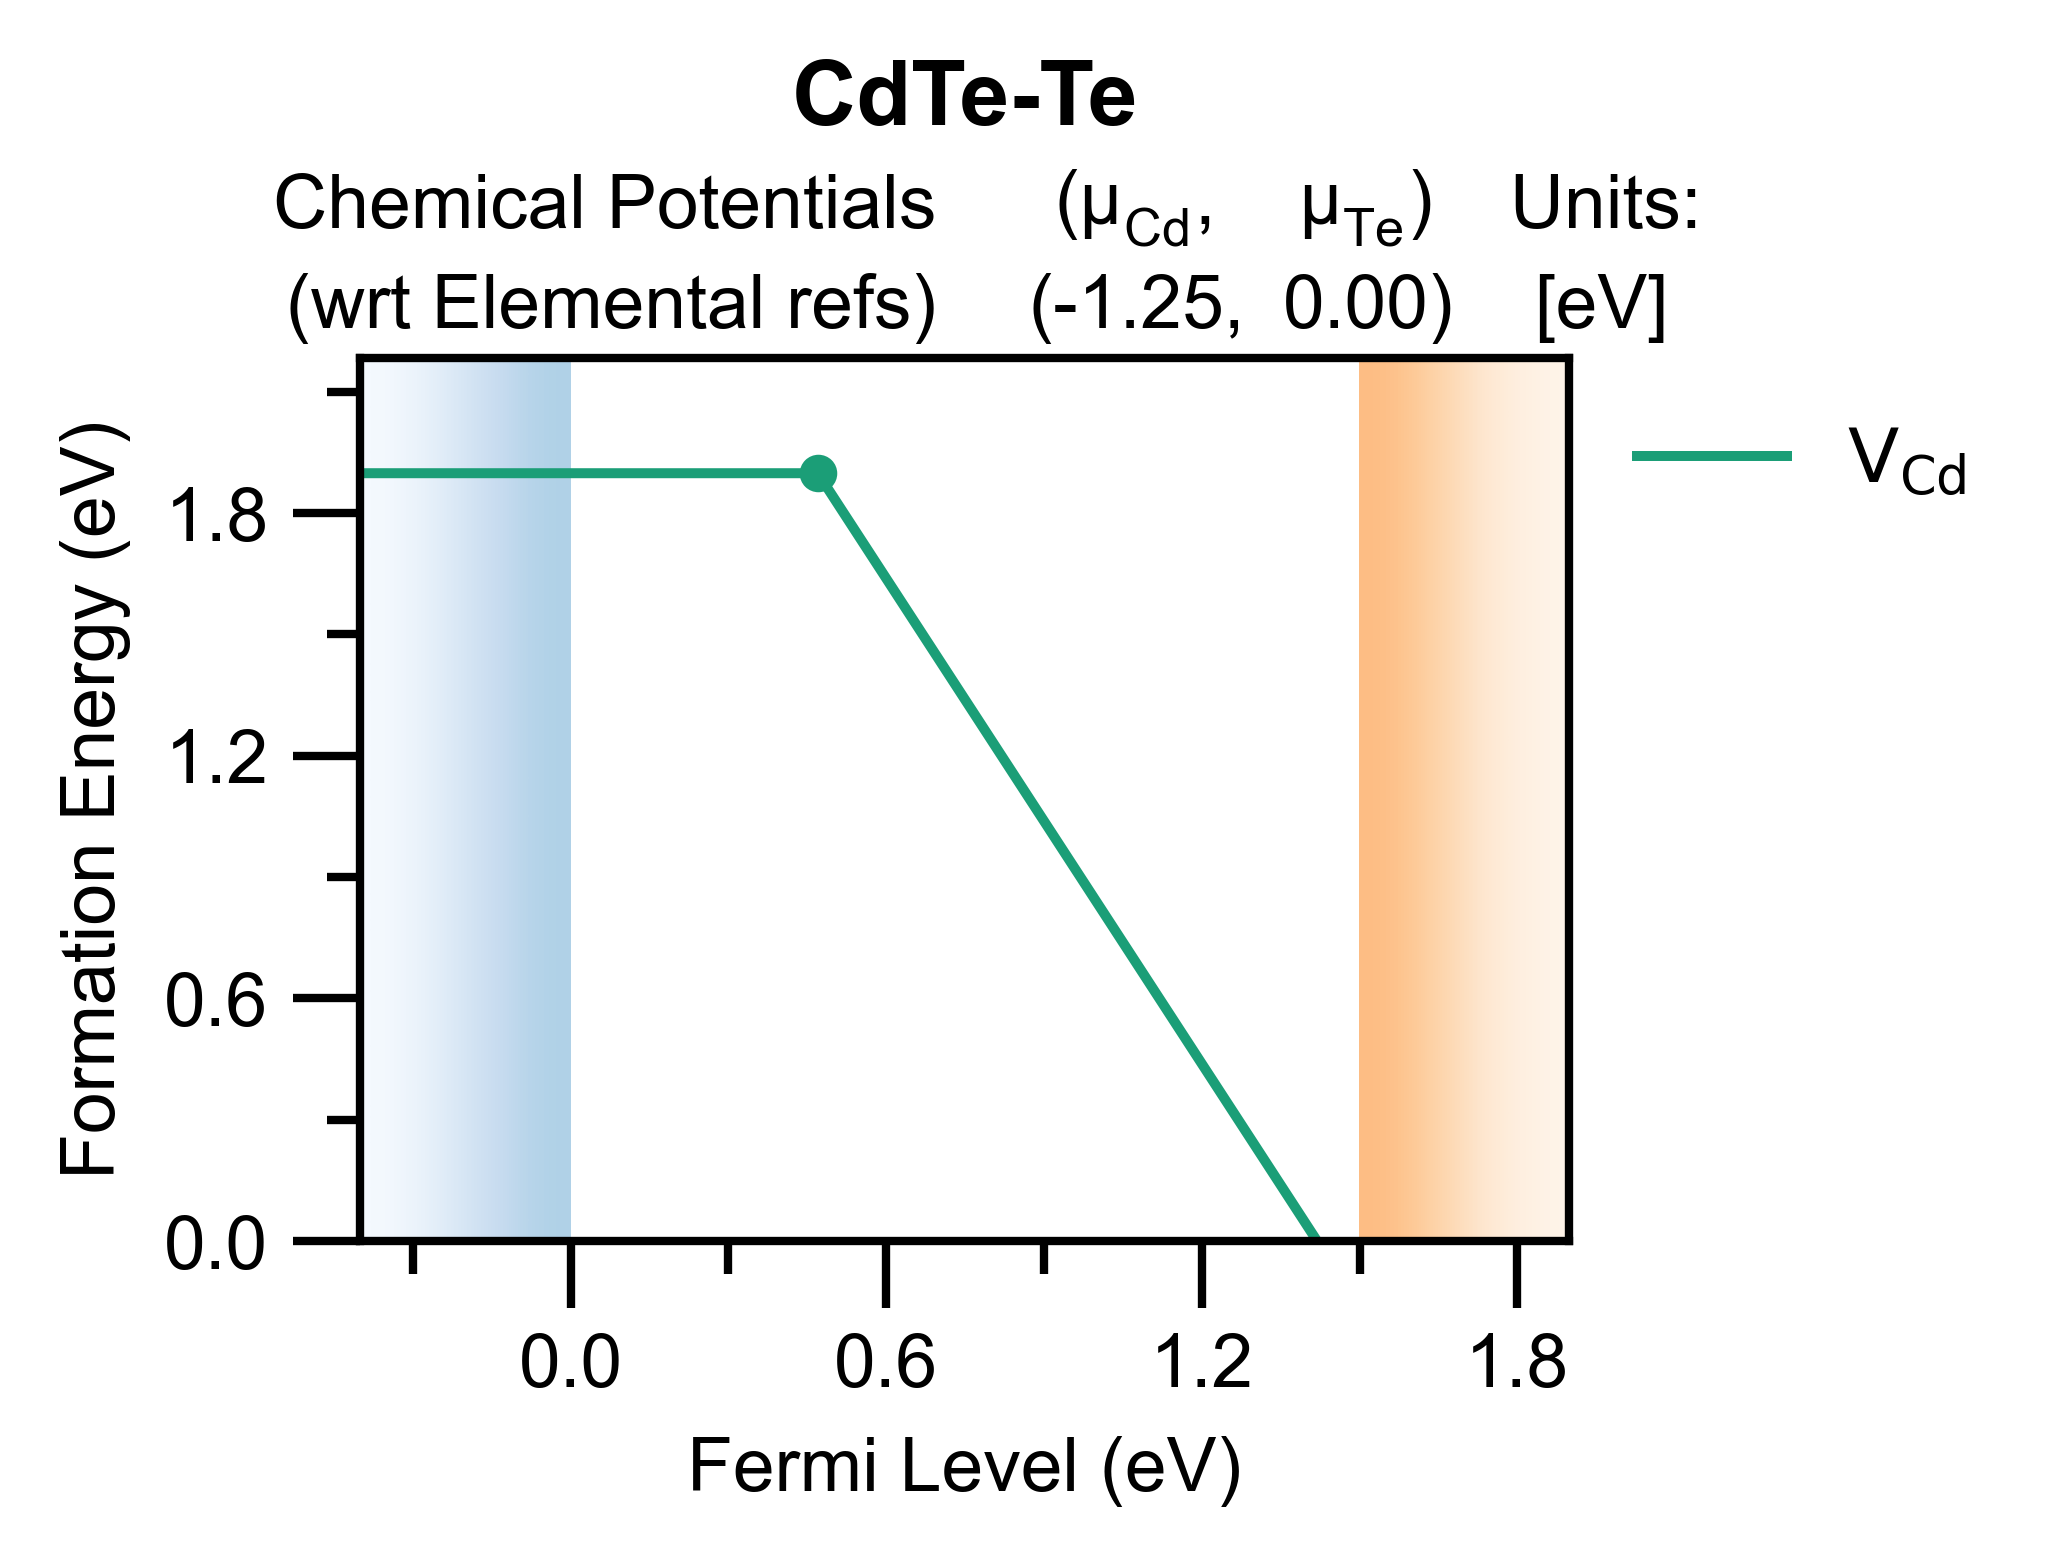

In [17]:
def_plot = dope_stuff.formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    pd_facets=["CdTe-Te"],
)

There are a lot of options for making the formation energy plot prettier:

In [18]:
dope_stuff.formation_energy_plot?  # run this cell to see the possible arguments for this function

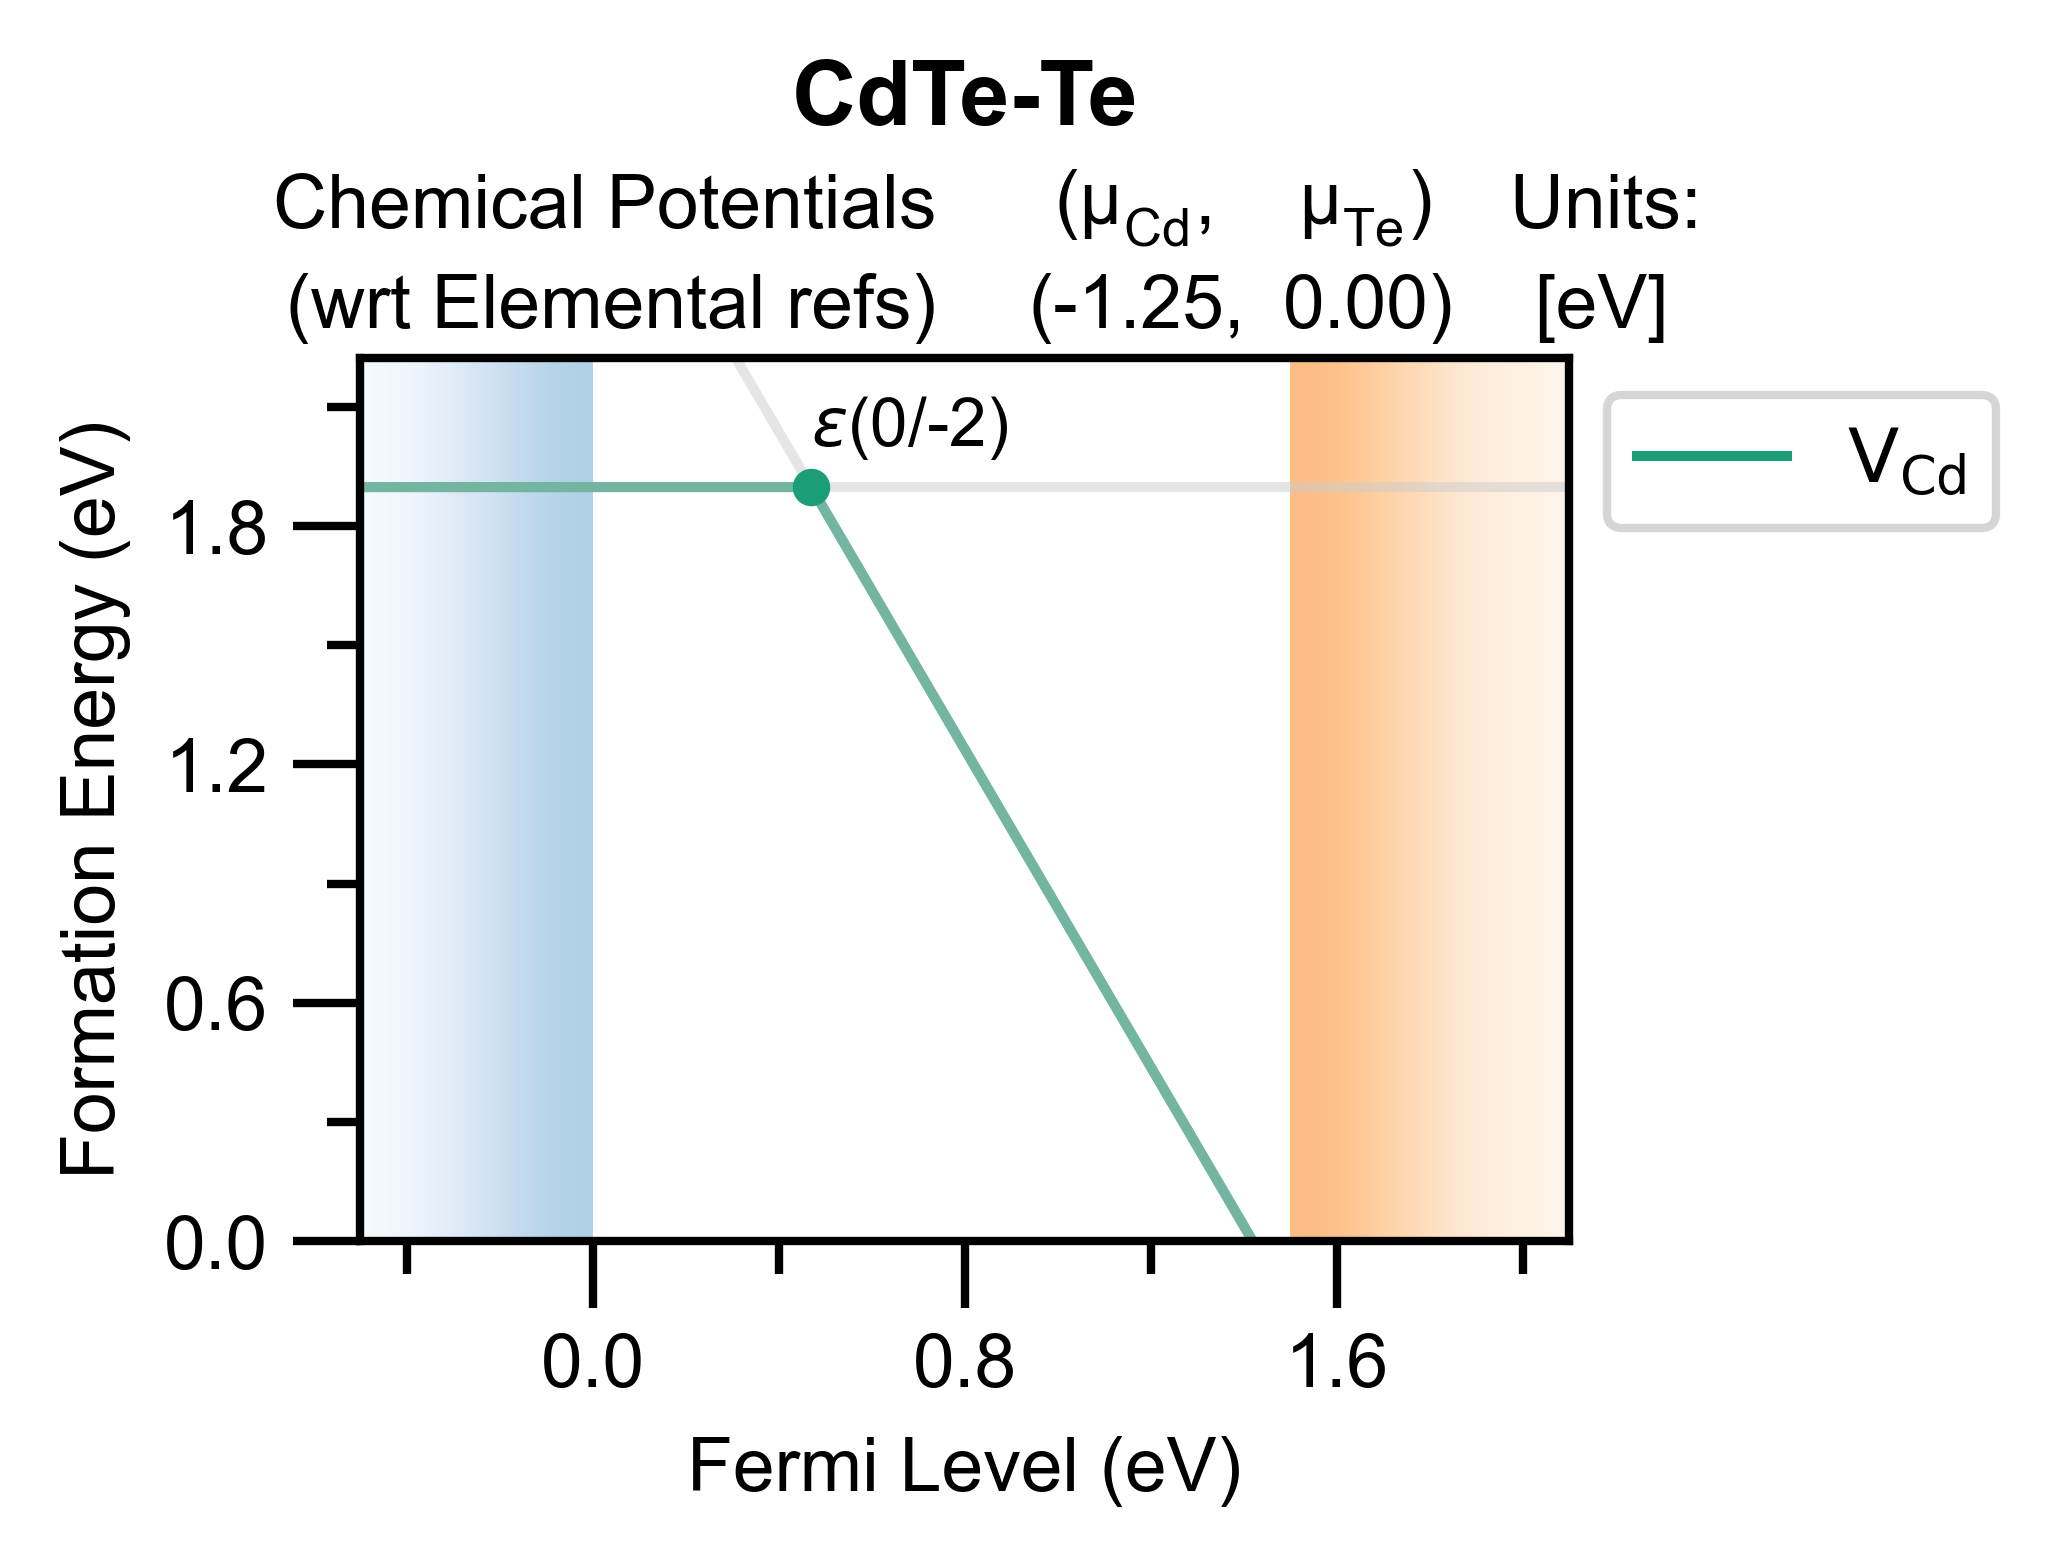

In [19]:
def_plot = dope_stuff.formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    auto_labels=True,
    xlim=(-0.5, 2.1),
    emphasis=True,
    frameon=True,
    pd_facets=["CdTe-Te"],
    saved=True, # Save plot and give filename
    filename="Examples/V_Cd_Formation_Energy_Te-Rich.pdf"
)

`dope_stuff.formation_energy_plot` also returns the `matplotlib` plot object, so you can customise this as much as you like!

**Manually inputting chemical potentials:**

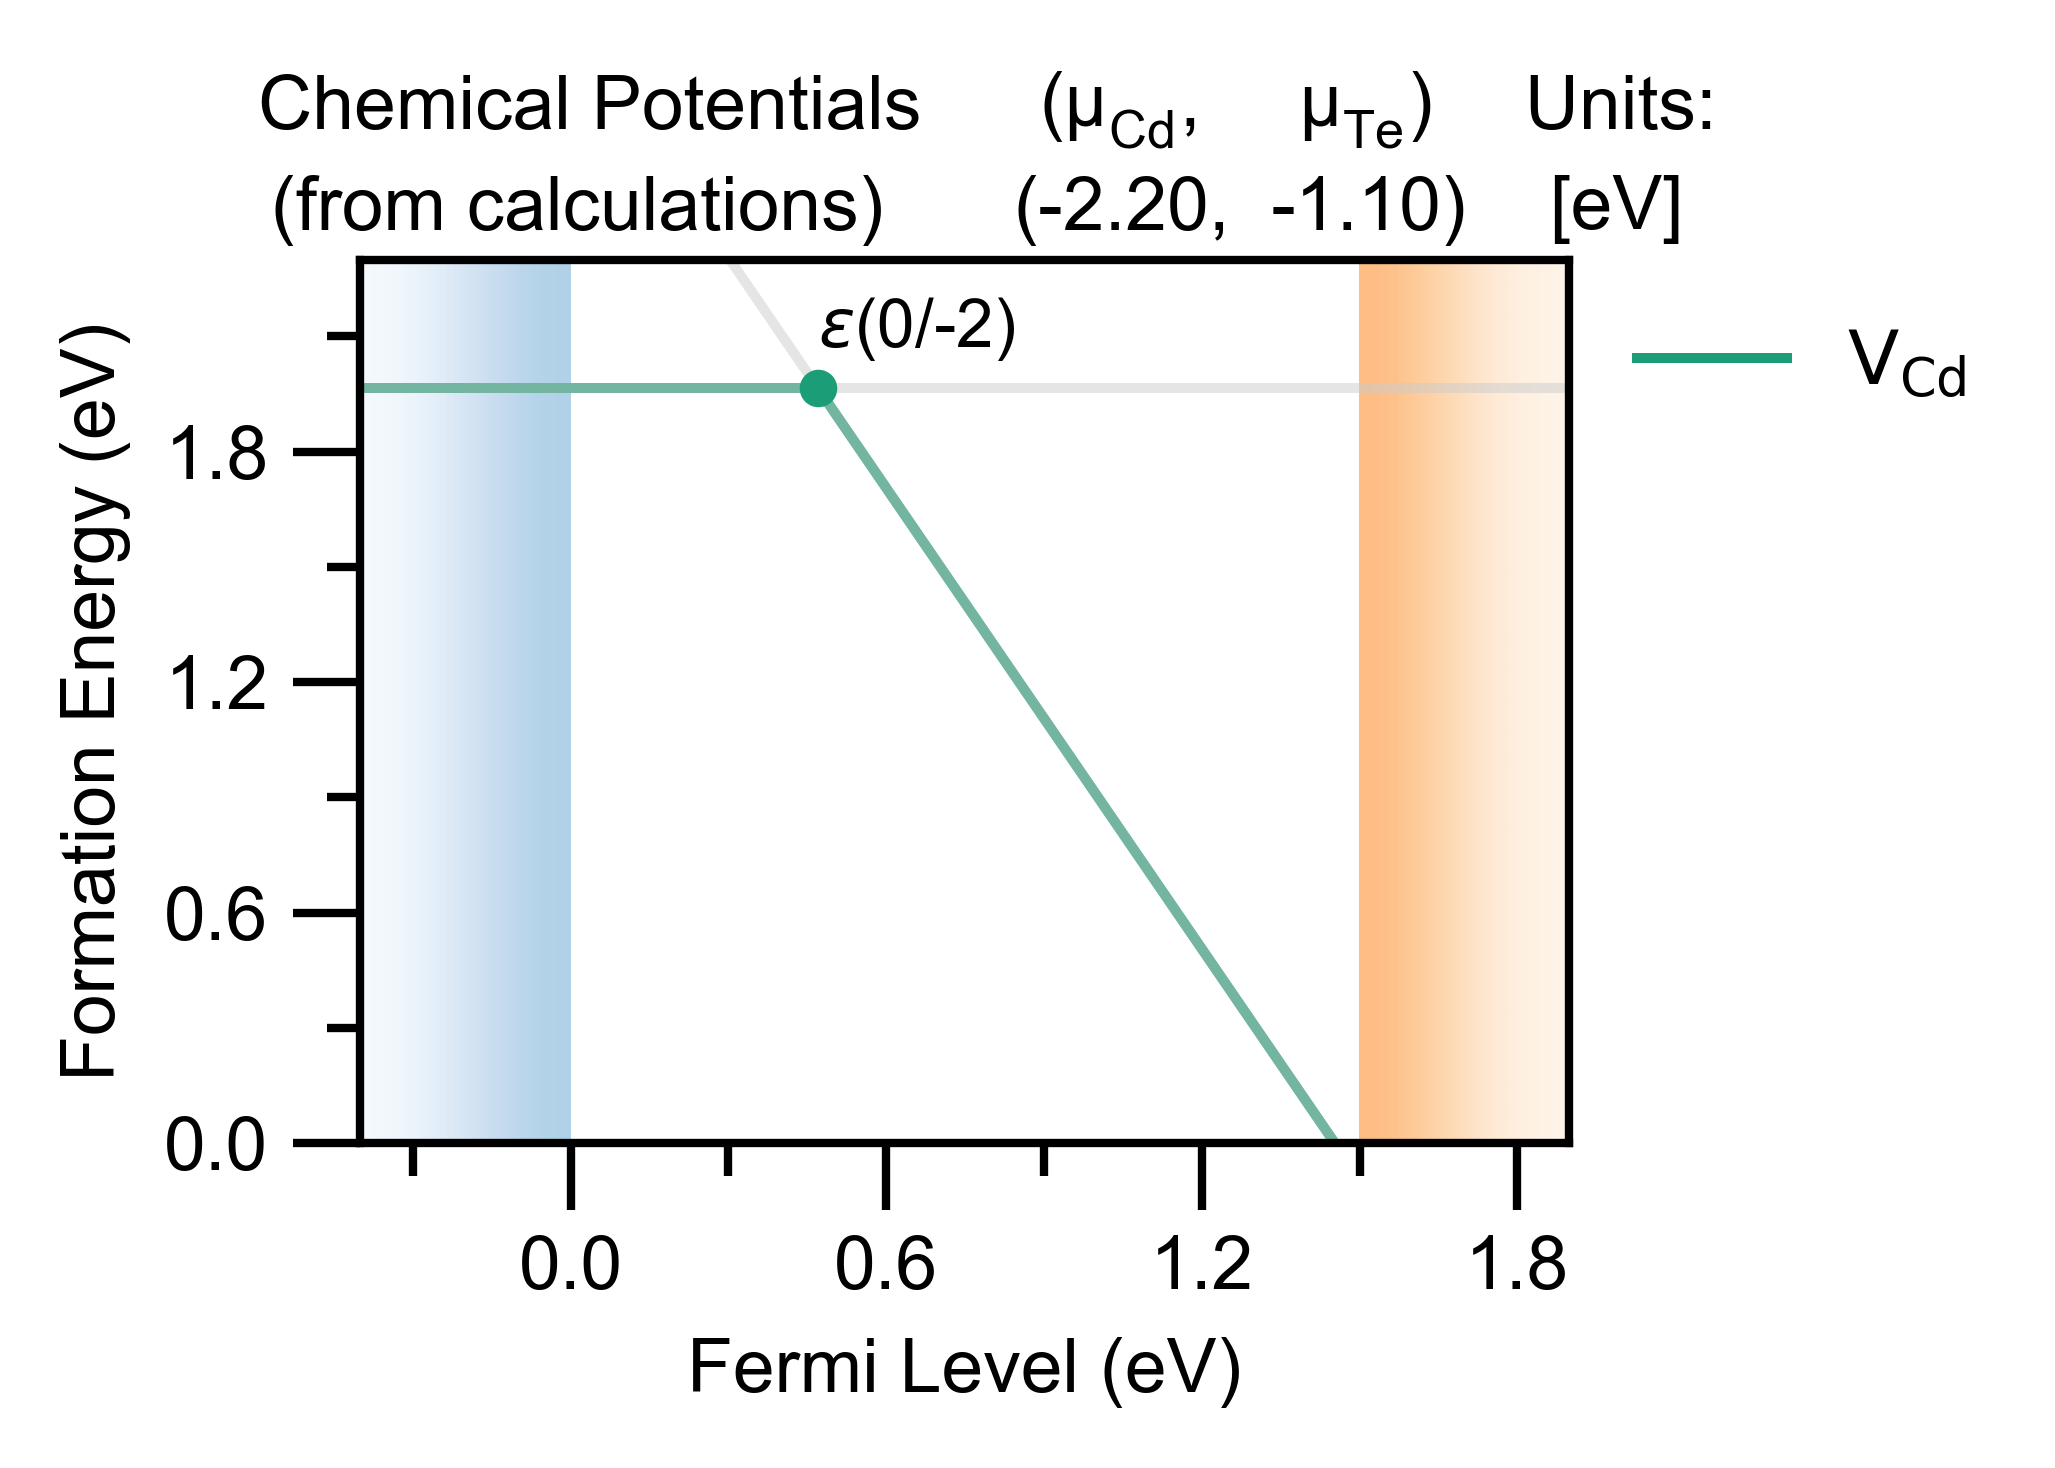

In [20]:
def_plot = dope_stuff.formation_energy_plot(
    vac_Cd_dpd,
    chempot_limits = {"Cd": -2.2, "Te": -1.1},
    auto_labels=True,
    emphasis=True,
)

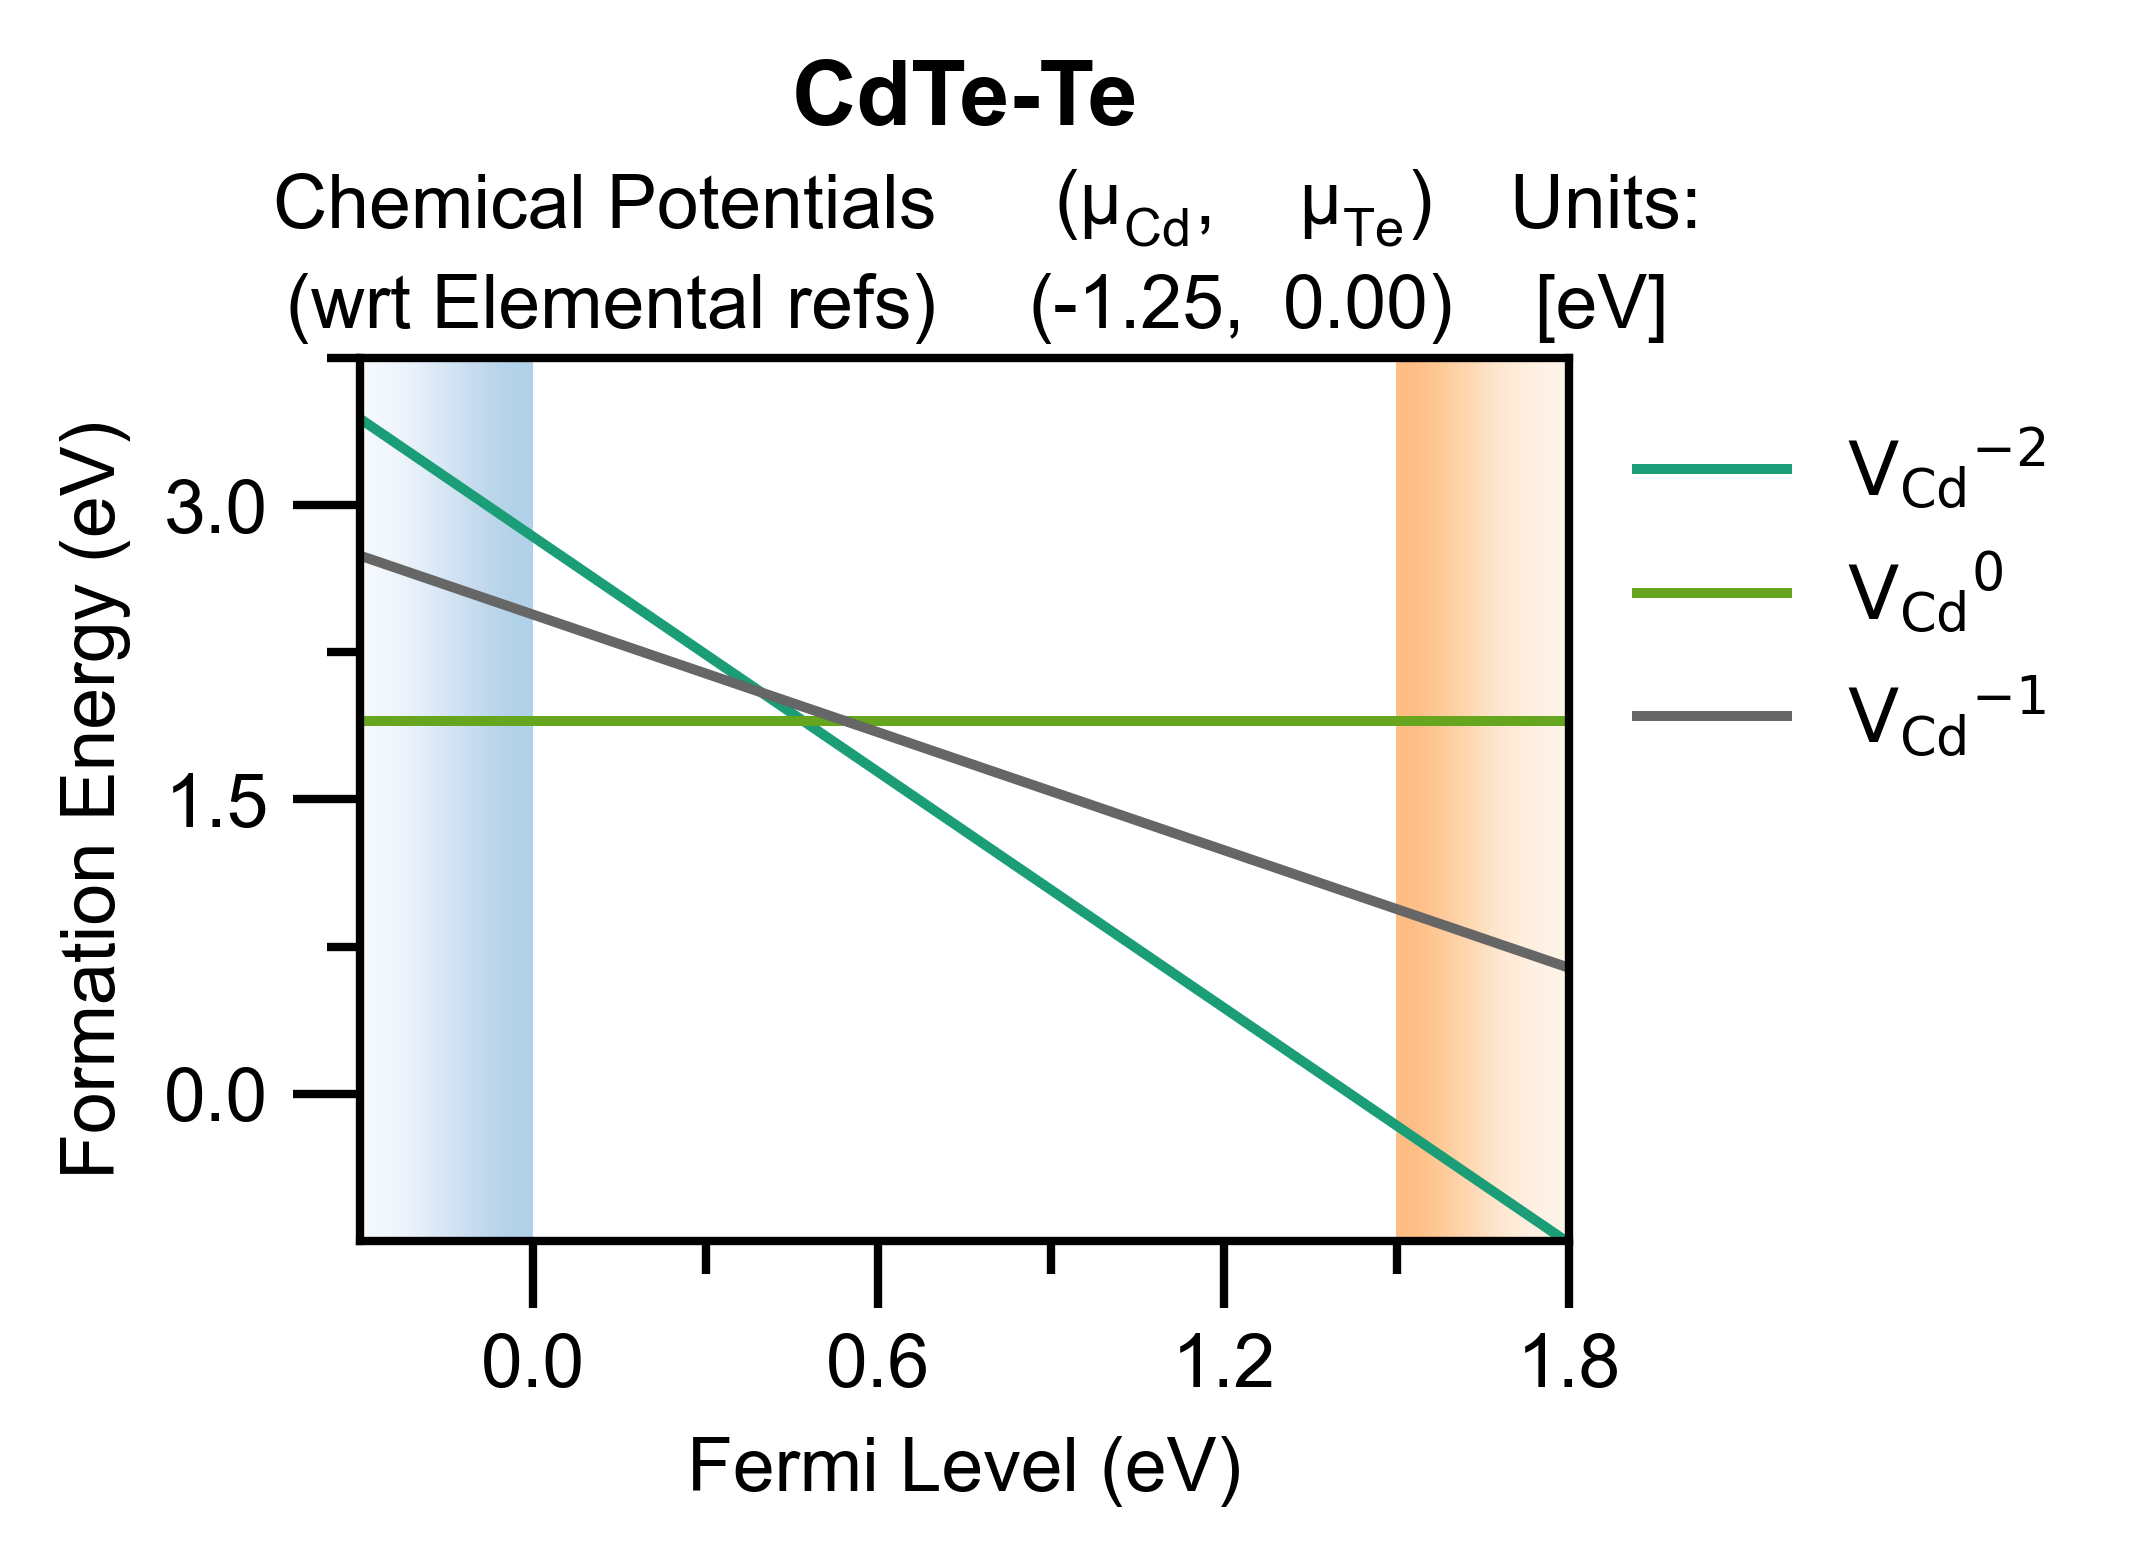

In [21]:
def_plot = dope_stuff.all_lines_formation_energy_plot(
    vac_Cd_dpd,
    cdte_chempots,
    auto_labels=False,
    xlim=(-0.3, 1.8),
    ylim=(-0.75,3.75),
    pd_facets=["CdTe-Te"],
    filename="Examples/V_Cd_Te-Rich_All_Lines.pdf"
)

If you have parsed all your calculated defects as above with `doped` and created the `DefectPhaseDiagram` object (e.g. `CdTe_defects_dpd` in this example), you can also plot the formation energies of all the defects together, as shown below:

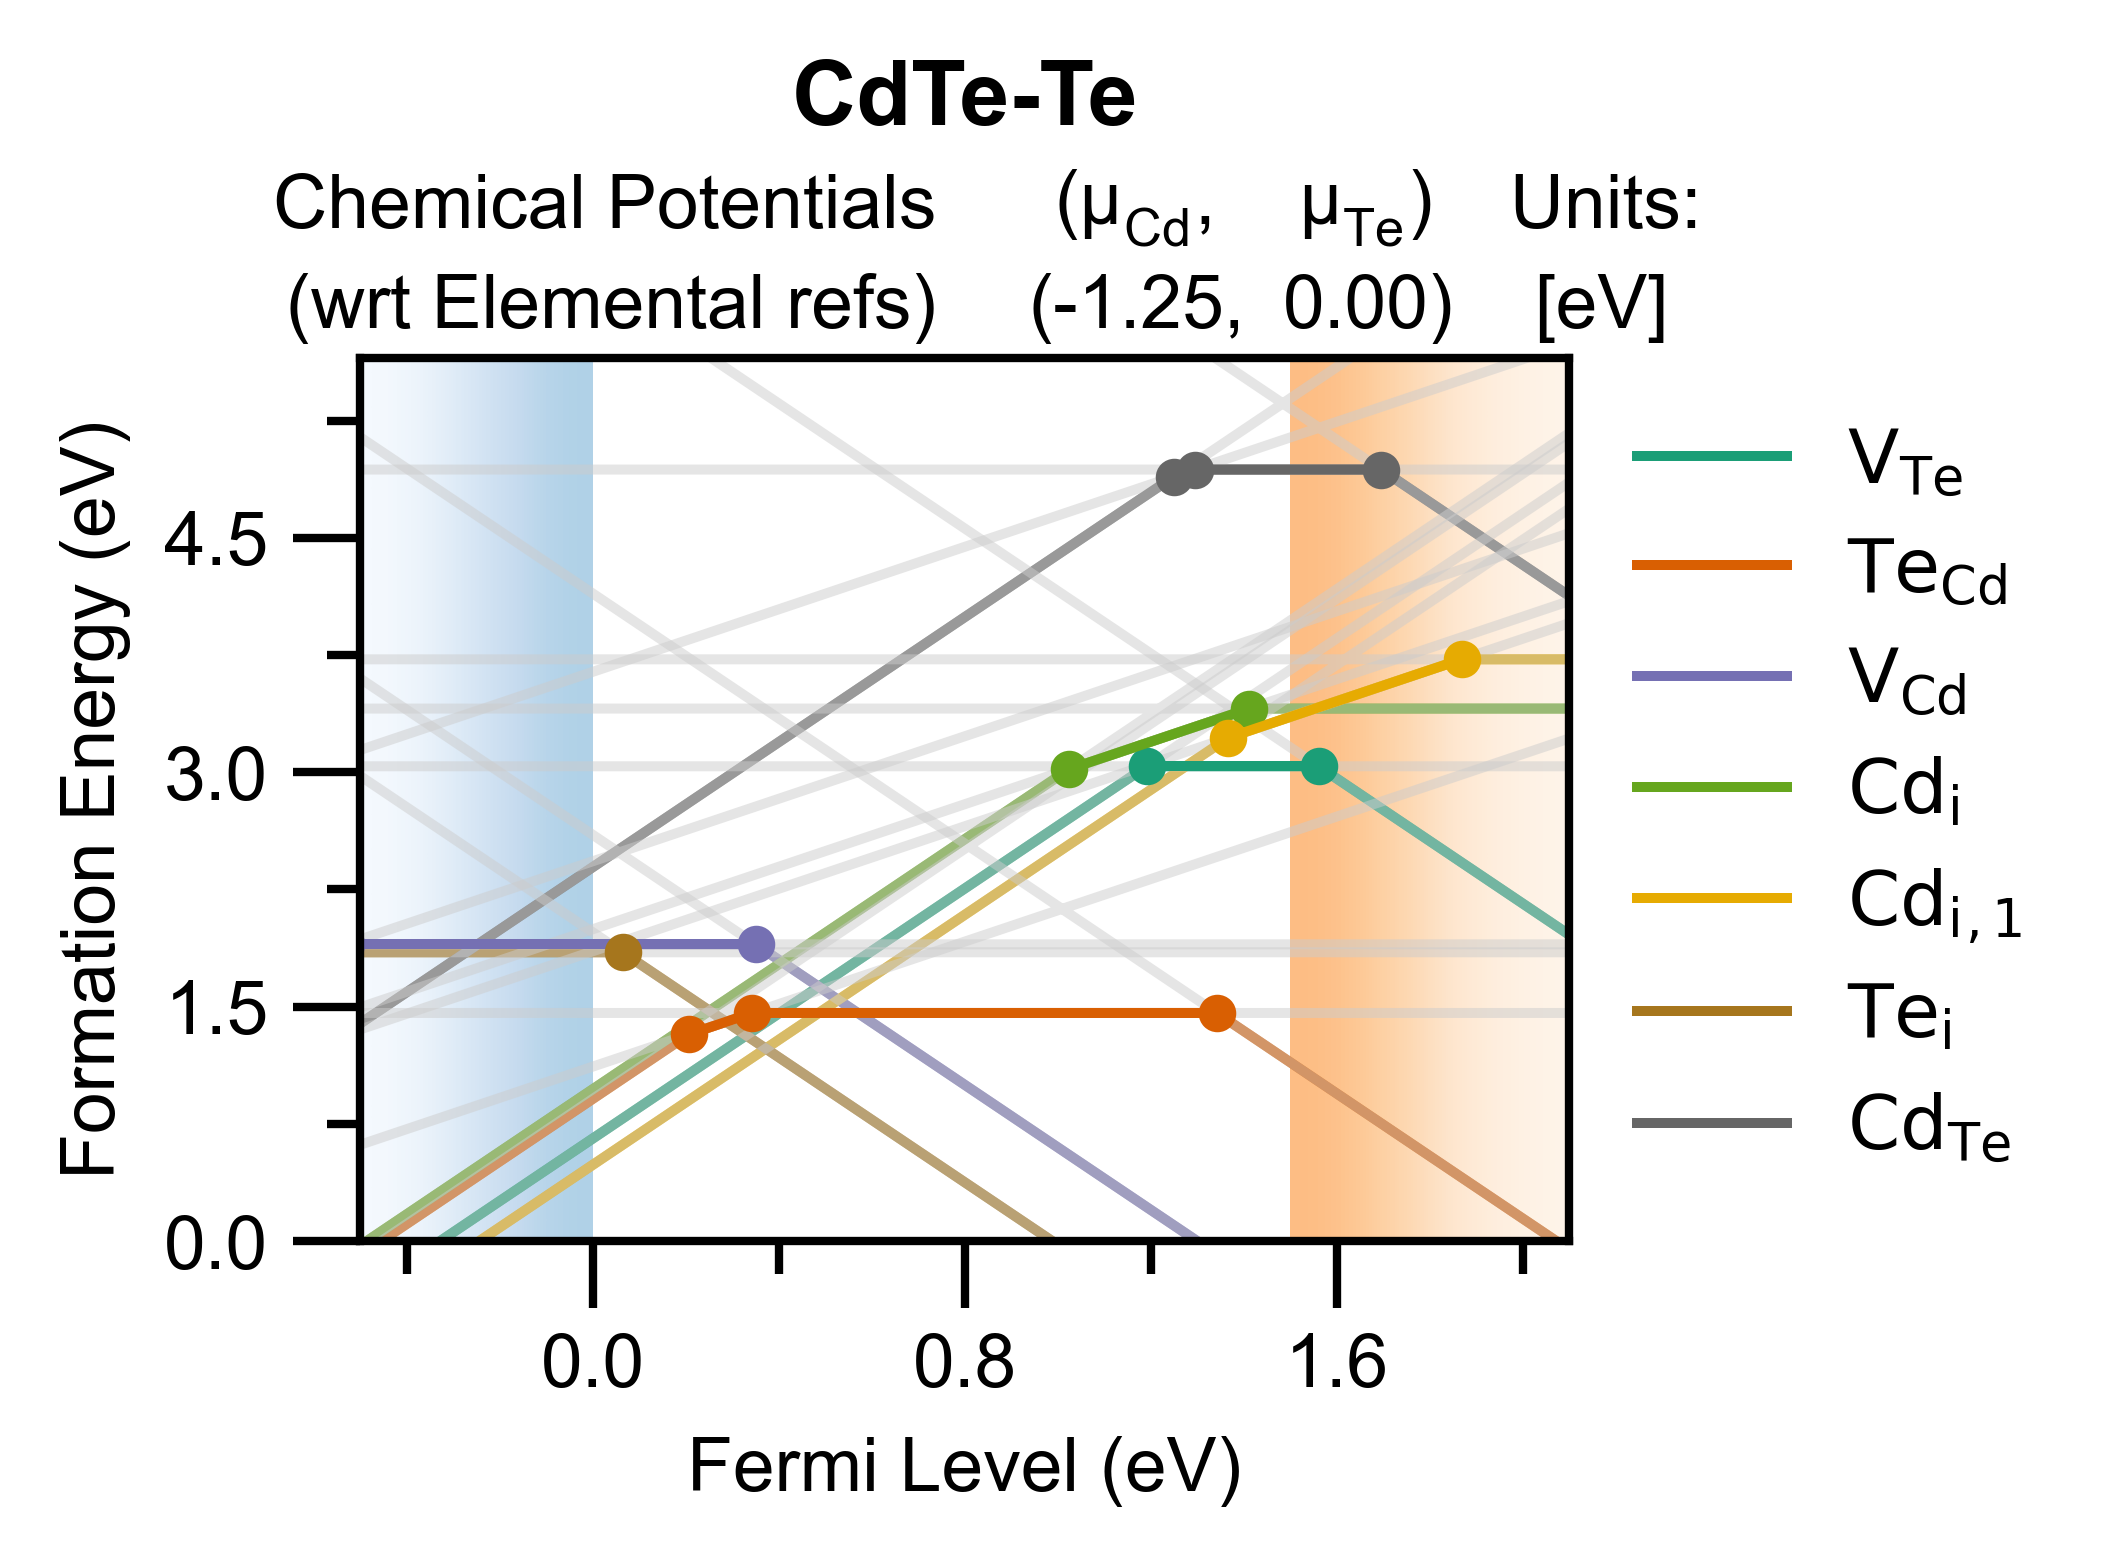

In [21]:
# Example plot of final results:
# def_plot = dope_stuff.formation_energy_plot(
#     CdTe_defects_dpd,
#     cdte_chempots,
#     #auto_labels=True,
#     xlim=(-0.5, 2.1),
#     emphasis=True,
#     pd_facets=["CdTe-Te"],
# )

# $V_{Cd}^{0}$ Concentrations

The files for these examples are not provided in the repository, but are shown here to demonstrate some of the other post-processing of defect calculation results you can do with `doped`:

In [ ]:
vac_Cd_0_sorted = sorted([defect for defect in CdTe_defects_dpd.entries if defect.name == "Vac_Cd_mult32" and defect.charge == 0], key=lambda x: x.energy)
vac_Cd_0_Te_dimer = vac_Cd_0_sorted[0]

In [ ]:
def_energy = lambda x: x.energy
def_energy(vac_Cd_0_sorted[0])

In [47]:
print(f"V_Cd^0 concentration in p-type CdTe at T=1000K: {vac_Cd_0_Te_dimer.defect_concentration(cdte_chempots['facets']['CdTe-Te'], temperature=1000, fermi_level = 0.3):.2E} cm^3")

V_Cd^0 concentration in p-type CdTe at T=1000K: 3.86E+12 cm^3


In [46]:
print(f"V_Cd^0 formation energy in p-type CdTe: {vac_Cd_0_Te_dimer.formation_energy(cdte_chempots['facets']['CdTe-Te'], fermi_level = 0.3):.3f} eV")

V_Cd^0 formation energy in p-type CdTe: 1.899 eV


In [70]:
from doped.pycdt.utils.parse_calculations import get_vasprun

In [71]:
CdTe_dos_vr, CdTe_dos_vr_path = get_vasprun("prim_cell_DOS/vasprun.xml.gz")

In [75]:
T = 273.15 + 750 # 750 degrees C
CdTe_defects_dpd.solve_for_fermi_energy(T, cdte_chempots["facets"]["CdTe-Te"], CdTe_dos_vr.complete_dos)

0.5158090324034222

In [79]:
print(f"V_Cd^0 concentration in p-type CdTe at T=1000K: {vac_Cd_0_Te_dimer.defect_concentration(cdte_chempots['facets']['CdTe-Te'], temperature=T, fermi_level = 0.5158):.2E} cm^3")

V_Cd^0 concentration in p-type CdTe at T=1000K: 6.35E+12 cm^3
